# GAN From Scratch

Using the paper: [Generative Adversarial Networks by Goodfellow et. al](https://arxiv.org/abs/1406.2661)

### Pytorch Implementation
This is the first time I'm using Pytorch Framework and implementing a GAN. I receive help from the following video at the places I'm stuck: https://www.youtube.com/watch?v=OljTVUVzPpM&list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&index=2&t=33s

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms


### Discriminator

In [2]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

### Generator

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_features):
        super().__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(z_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, in_features),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 784)
        return img


### Hyperparameters and initializations

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4 
z_dim = 64
image_dim = 28 * 28
batch_size = 32
num_epochs = 50

disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)


Prepare data

In [5]:
import torchvision.transforms as T  # Alias the transforms module

transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.5,), (0.5,)),
    ]
)

dataset = datasets.MNIST(root="dataset", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Optimizers & Loss

In [6]:
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()


### Training Loop

In [12]:
from torchvision.utils import save_image
for epoch in range(num_epochs):
   
    for i, (real, _) in enumerate(loader):
       
        real = real.view(-1,784).to(device) # flatten everything, -1 for keeping all data
        batch_size = real.shape[0]

        # train disc: max log(D(real)) + log(1-G(G(z)))
        noise = torch.randn((batch_size, z_dim)).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossd_real = criterion((disc_real), torch.ones_like(disc_real))
        # in generator, we want 'fake' which was deleted after .backward() thus detach fake from graph
        disc_fake = disc(fake.detach()).view(-1)
        lossd_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossd = (lossd_real + lossd_fake) / 2
        disc.zero_grad()
        lossd.backward(retain_graph=True) # another way to detach 
        opt_disc.step()

        #train generator: min log(1-D(G(z))) --> better to max log(D(G(z)))
        output = disc(fake).view(-1)
        lossg = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossg.backward()
        opt_gen.step()
        if i == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(loader)} \
                      Loss D: {lossd:.4f}, loss G: {lossg:.4f}"
            )
       
       

Epoch [0/50] Batch 0/1875                       Loss D: 0.2918, loss G: 7.4871
Epoch [1/50] Batch 0/1875                       Loss D: 0.0515, loss G: 4.8693
Epoch [2/50] Batch 0/1875                       Loss D: 0.1211, loss G: 8.9491
Epoch [3/50] Batch 0/1875                       Loss D: 0.4132, loss G: 5.6888
Epoch [4/50] Batch 0/1875                       Loss D: 0.2068, loss G: 3.3105
Epoch [5/50] Batch 0/1875                       Loss D: 0.3103, loss G: 5.6366
Epoch [6/50] Batch 0/1875                       Loss D: 0.1134, loss G: 3.5957
Epoch [7/50] Batch 0/1875                       Loss D: 0.2661, loss G: 4.8606
Epoch [8/50] Batch 0/1875                       Loss D: 0.2662, loss G: 3.9802
Epoch [9/50] Batch 0/1875                       Loss D: 0.3591, loss G: 2.8677
Epoch [10/50] Batch 0/1875                       Loss D: 0.2818, loss G: 2.3585
Epoch [11/50] Batch 0/1875                       Loss D: 0.3050, loss G: 3.0474
Epoch [12/50] Batch 0/1875                       L

### Generate images

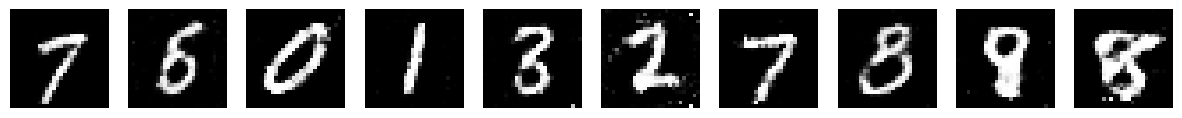

In [19]:
import matplotlib.pyplot as plt

gen.eval()

# Generate random noise as input
batch_size = 10  # Number of images to generate
noise = torch.randn(batch_size, z_dim).to(device)

# Generate images
with torch.no_grad():  # We don't need to track gradients here
    fake_images = gen(noise)

# Reshape images to 28x28 for MNIST
fake_images = fake_images.view(batch_size, 28, 28).cpu().detach().numpy()

fig, axs = plt.subplots(1, batch_size, figsize=(15, 15))
for i in range(batch_size):
    axs[i].imshow(fake_images[i], cmap='gray')
    axs[i].axis('off')
plt.show()


## Save Model


In [16]:
torch.save(gen.state_dict(), "generator_model")
torch.save(disc.state_dict(), "discriminator_model")